In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, BatchNormalization, Activation, Dropout
from keras.models import Model

import tensorflow as tf
import sys
sys.path.append('../src/')
import vcf2onehot

from keras.models import load_model

In [29]:
STAR_SAMPLE = '../data/final_model/star_samples.vcf'

CURATED_FUNCTION = '../data/final_model/pcbi.1008399.s003.xlsx'
# CURATED_FUNCTION = '../data/final_model/star_scores.csv'

PATH_LABEL_SAVE = '../data/final_model/labels_alleles.csv'

In [30]:
alleles_function = pd.read_excel(CURATED_FUNCTION, usecols=[0, 1])

In [31]:
alleles_function

,CYP2D6 Star Allele,Curated Function
0,*1,Normal
1,*2,Normal
2,*3,No function
3,*4,No function
4,*6,No function
...,...,...
122,*135,Uncurated
123,*136,Uncurated
124,*137,Uncurated
125,*138,Uncurated


In [32]:
samples = []
with open(STAR_SAMPLE) as f:
    for line in f:
        if line.startswith("#CHROM"):
            samples = line.strip().split()[9:]
            break


In [33]:
labels = []
for sample in samples:
    star = "*" + str(sample.split("_")[1])
    label = alleles_function[alleles_function["CYP2D6 Star Allele"] == star]["Curated Function"].values[0]

    if label == "Uncurated":
        no_function = None
        normal_function = None
    else:
        no_function = 0 if label == "No function" else 1
        normal_function = 1 if label == "Normal" else 0

    labels.append([sample, no_function, normal_function])

In [34]:
label_df = pd.DataFrame(labels)
label_df.to_csv(PATH_LABEL_SAVE, index=False, header=None)
print("Saved labels to %s" % PATH_LABEL_SAVE)

Saved labels to ../data/final_model/labels_alleles.csv


In [35]:
seqs = vcf2onehot.build_seqs(STAR_SAMPLE)
data = vcf2onehot.format_seqs(seqs)
data['y'] = pd.read_csv(PATH_LABEL_SAVE, header=None, index_col=0).loc[samples].values

In [36]:
mask = np.all(np.isnan(data['y']) == False, axis=1)

sample_y = data['y'][mask]
sample_X = data['X'][mask]
sample_names = data['sample_names'][mask]

In [37]:
all_stars = np.array([s.split('_')[1] for s in sample_names])
stars, idx = np.unique(all_stars, return_index=True)

In [38]:
all_stars

array(['100', '10', '10', '10', '10', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '100', '101', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '101', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '10', '11', '114', '114', '11', '12', '12', '12',
       '14', '14', '15', '15', '15', '15', '17', '17', '17', '17', '18',
       '18', '19', '19', '20', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '20',
       '21', '21', '21', '27', '27', '29', '29', '3', '3', '31', '31',
       '33', '33', '34', '35', '35', '35', '35', '35', '35', '35', '35',
       '36', '36', '36', '38', '38', '39', '3', '40', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4',
       '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '40', '41',
       '41', '41', '41', '41', '41', '42', '42', '44', '44', '45', '45',
       '45', '46', '46', '46', '46', '47', '47', '48', '

In [39]:
stars.shape

(55,)

In [40]:
stars

array(['1', '10', '100', '101', '11', '114', '12', '14', '15', '17', '18',
       '19', '2', '20', '21', '27', '29', '3', '31', '33', '34', '35',
       '36', '38', '39', '4', '40', '41', '42', '44', '45', '46', '47',
       '48', '49', '50', '51', '53', '54', '55', '56', '57', '59', '6',
       '60', '62', '69', '7', '72', '8', '84', '9', '92', '96', '99'],
      dtype='<U3')

In [41]:
sample_y[idx].shape

(55, 2)

In [42]:
np.unique(sample_y[idx], return_counts=True, axis=0)


(array([[0., 0.],
        [1., 0.],
        [1., 1.]]),
 array([31, 13, 11], dtype=int64))

In [43]:
train_idx, test_idx = train_test_split(idx, stratify=sample_y[idx], test_size=24, random_state=1)

In [44]:
train_idx

array([175, 153,  42,  63, 199, 181, 143,  41, 185,  97, 177,  91, 203,
       151,  98, 160, 169,   5, 186, 202, 198,  89, 195,  54,  45,  58,
       164,  87, 193, 114, 109], dtype=int64)

In [45]:
test_idx

array([171, 113,   0,  93,  50, 162, 209,  48,   1, 156, 111, 183, 149,
       167,  62, 211, 173, 207, 106,  15,  60,  84, 213,  95], dtype=int64)

In [46]:
sample_mask = np.isin(all_stars, all_stars[train_idx])

In [47]:
test_stars = np.array([s for s in sample_names[~sample_mask] if s.split('_')[-1] == '001'])
test_mask = np.isin(sample_names, test_stars)

train_stars = np.array([s for s in sample_names[sample_mask] if s.split('_')[-1] == '001'])
train_mask = np.isin(sample_names, train_stars)

# Split the data into the two sets - INCLUDING SUBALLES ON BOTH
_train_X, test_X = sample_X[sample_mask], sample_X[~sample_mask]
_train_y, test_y = sample_y[sample_mask], sample_y[~sample_mask]

# Purely for evaluation (paper looks at star allele accuracy rather than star + suballeles)
star_train_X, star_test_X = sample_X[train_mask], sample_X[test_mask]
star_train_y, star_test_y = sample_y[train_mask], sample_y[test_mask]

In [48]:
star_train_X.shape, star_test_X.shape

((31, 14868, 13), (24, 14868, 13))

In [49]:
np.unique(star_train_y, return_counts=True, axis=0), np.unique(star_test_y, return_counts=True, axis=0)

((array([[0., 0.],
         [1., 0.],
         [1., 1.]]),
  array([18,  7,  6], dtype=int64)),
 (array([[0., 0.],
         [1., 0.],
         [1., 1.]]),
  array([13,  6,  5], dtype=int64)))

In [50]:
_train_ds = tf.data.Dataset.from_tensor_slices((_train_X, _train_y))
train_ds = _train_ds.repeat().shuffle(_train_X.shape[0], reshuffle_each_iteration=True).batch(32).prefetch(buffer_size=10)

_test_ds = tf.data.Dataset.from_tensors((test_X, test_y))
test_ds = _test_ds.prefetch(buffer_size=10)

In [51]:
# Uncurated star alleles
uncurated_samples = data['sample_names'][~mask]
uncurated_stars = np.array([s for s in uncurated_samples if s.split('_')[-1] == '001'])
uncurated_star_mask = np.isin(uncurated_samples, uncurated_stars)

uncurated_samples = uncurated_samples[uncurated_star_mask]
uncurated_X = data['X'][(~mask).reshape(-1, 1).any(axis=1)]
uncurated_X = uncurated_X[uncurated_star_mask]

In [52]:
uncurated_X.shape

(71, 14868, 13)

In [26]:
def get_model_pretrained():
    PATH_MODEL = '../save_model/FinalModel/final_25-03-2024_02-32/model.h5'
    model = load_model(PATH_MODEL)
    return model

In [27]:
def create_transfer_model():
    model = get_model_pretrained()
    model.pop()
    model.pop()
    model.pop()
    model.trainable = False

    layer = Dense(units=32, activation='relu', name='dense5')(model.output)
    layer = Dropout(0.3, name='dropout_4')(layer)
    layer = Dense(units=1, activation='linear', name='dense6')(layer)
    outputs = Dense(units=2, activation='sigmoid')(layer)

    transfer_model = Model(inputs=model.input, outputs=outputs, name='transfer_model')
    
    return transfer_model
    

In [142]:
def build_and_fit(dataset):
    model = create_transfer_model()
    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.AUC()]
              )
    model.fit(dataset, steps_per_epoch=128 ,epochs=10, verbose=True)
    
    return model
    

In [143]:
model = create_transfer_model()
model.summary()

Model: "transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1_input (InputLayer  [(None, 14868, 13)]       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2970, 70)          17360     
                                                                 
 batch_1 (BatchNormalizatio  (None, 2970, 70)          280       
 n)                                                              
                                                                 
 relu_1 (ReLU)               (None, 2970, 70)          0         
                                                                 
 maxpooling_1 (MaxPooling1D  (None, 990, 70)           0         
 )                                                               
                                                    

In [144]:
ensemble_size = 7

for i in range(ensemble_size):
    print(f"ensemble_{i}.model.h5")
    model = build_and_fit(train_ds)

    model.save(f'../save_model/ensemble_{i}.model.h5')

ensemble_0.model.h5
Epoch 1/10
128/128 [==============================] - 6s 42ms/step - loss: 0.2367 - auc_16: 0.6231
Epoch 2/10
128/128 [==============================] - 7s 55ms/step - loss: 0.2110 - auc_16: 0.7005
Epoch 3/10
128/128 [==============================] - 8s 60ms/step - loss: 0.1948 - auc_16: 0.7498
Epoch 4/10
128/128 [==============================] - 8s 60ms/step - loss: 0.1761 - auc_16: 0.7755
Epoch 5/10
128/128 [==============================] - 8s 60ms/step - loss: 0.1558 - auc_16: 0.7867
Epoch 6/10
128/128 [==============================] - 7s 52ms/step - loss: 0.1351 - auc_16: 0.8973
Epoch 7/10
128/128 [==============================] - 7s 51ms/step - loss: 0.0847 - auc_16: 0.9567
Epoch 8/10
128/128 [==============================] - 7s 54ms/step - loss: 0.0633 - auc_16: 0.9741
Epoch 9/10
128/128 [==============================] - 7s 53ms/step - loss: 0.0542 - auc_16: 0.9804
Epoch 10/10
128/128 [==============================] - 7s 55ms/step - loss: 0.0485 - auc_

c:\anaconda3\envs\ml-hus\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
128/128 [==============================] - 8s 49ms/step - loss: 0.1472 - auc_17: 0.8828
Epoch 2/10
128/128 [==============================] - 6s 50ms/step - loss: 0.0852 - auc_17: 0.9590
Epoch 3/10
128/128 [==============================] - 7s 52ms/step - loss: 0.0670 - auc_17: 0.9752
Epoch 4/10
128/128 [==============================] - 6s 49ms/step - loss: 0.0568 - auc_17: 0.9830
Epoch 5/10
128/128 [==============================] - 6s 49ms/step - loss: 0.0517 - auc_17: 0.9862
Epoch 6/10
128/128 [==============================] - 7s 51ms/step - loss: 0.0468 - auc_17: 0.9880
Epoch 7/10
128/128 [==============================] - 7s 52ms/step - loss: 0.0432 - auc_17: 0.9887
Epoch 8/10
128/128 [==============================] - 6s 50ms/step - loss: 0.0400 - auc_17: 0.9889
Epoch 9/10
128/128 [==============================] - 7s 54ms/step - loss: 0.0383 - auc_17: 0.9881
Epoch 10/10
128/128 [==============================] - 7s 54ms/step - loss: 0.0361 - auc_17: 0.9884
ensemble_

In [1]:
class Ensemble():
    def __init__(self, X=None, dir='../model/FINAL_MODEL/'):
        self.X = X
        self.raw = None
        self.predictions = None
        self.dir = dir

        self.run()

    def run(self):
        predictions = self.predict(self.X).mean(axis=0)
        self.raw = predictions
        self.predictions = self.get_functions(predictions)

    def get_functions(self, pred):
        # cutpoint_1 = 0.4260022
        # cutpoint_2 = 0.7360413
        
        cutpoint_1 = 0.743              
        cutpoint_2 = 0.77   

        cut1 = np.greater(pred[:, 0], [cutpoint_1])
        cut2 = np.greater(pred[:, 1], [cutpoint_2])

        functions = []
        for i in range(pred.shape[0]):
            if cut1[i] == True and cut2[i] == True:
                functions.append("Normal Function")
            elif cut1[i] == True and cut2[i] == False:
                functions.append("Decreased Function")
            else:
                functions.append("No Function")

        return np.array(functions)

    def evaluate(self, y):
        labels = self.get_functions(y)
        return np.sum(labels == self.predictions) / len(y)

    def predict(self, X):
        from glob import glob
        models = glob(self.dir + "*.model.h5")
        
        predictions = []
        print("Predicting...")
        for m in models:
        # print(f"Predicting using {m}")
            model = tf.keras.models.load_model(m)
        
            pred = model.predict(X)
            predictions.append(pred)

        return np.array(predictions)

In [2]:
# Original paper attains 100% accuracy on training data star alleles

star_train_ensemble = Ensemble(star_train_X, dir='../model/FINAL_MODEL/')
print("\nTraining Accuracy (only star alleles):", star_train_ensemble.evaluate(star_train_y))

NameError: name 'star_train_X' is not defined

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

def build_heatmap(pred, y, labels):
  heatmap = []
  for label in labels:
    mask = pred == label
    masked_labels = y[mask]
    heatmap.append([len(masked_labels[masked_labels == l]) for l in reversed(labels)])

  return heatmap

Text(0.5, 1.0, 'Training set')

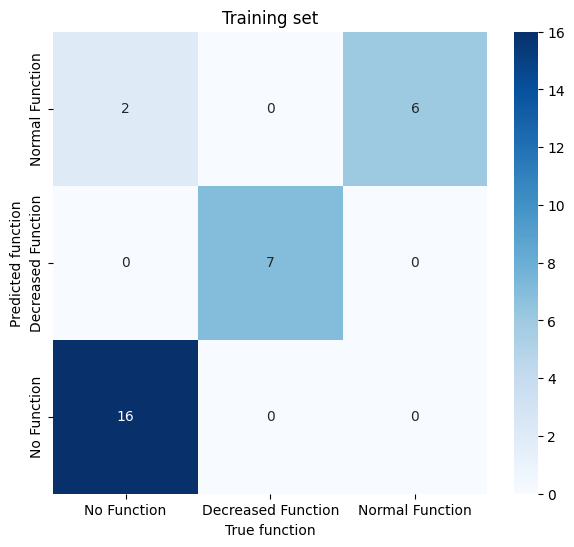

In [ ]:
labels = ["Normal Function", "Decreased Function", "No Function"]

train_labels = star_train_ensemble.get_functions(star_train_y)
train_heatmap = build_heatmap(star_train_ensemble.predictions, train_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)

sb.heatmap(train_heatmap, cmap="Blues", annot=train_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)

plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Training set")

Predicting...
2/2 [==============================] - 0s 42ms/step

Test Accuracy + suballeles: 0.7719298245614035


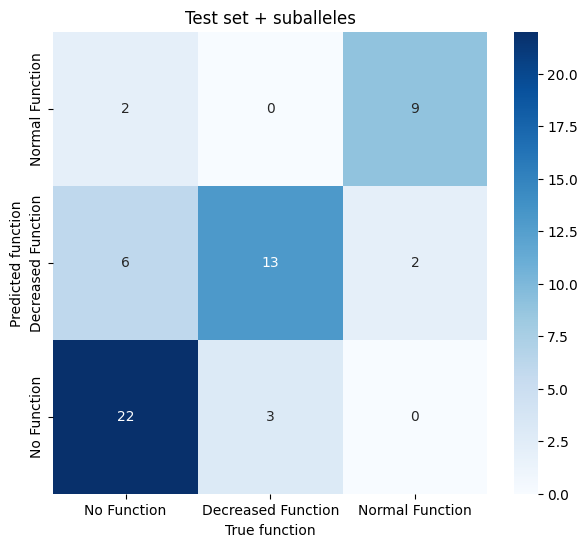

In [ ]:
# All test star alleles + suballeles

test_ensemble = Ensemble(test_X)
test_labels = test_ensemble.get_functions(test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Test set + suballeles")

print("\nTest Accuracy + suballeles:", test_ensemble.evaluate(test_y))

Predicting...
1/1 [==============================] - 0s 207ms/step

Test Accuracy: 0.875


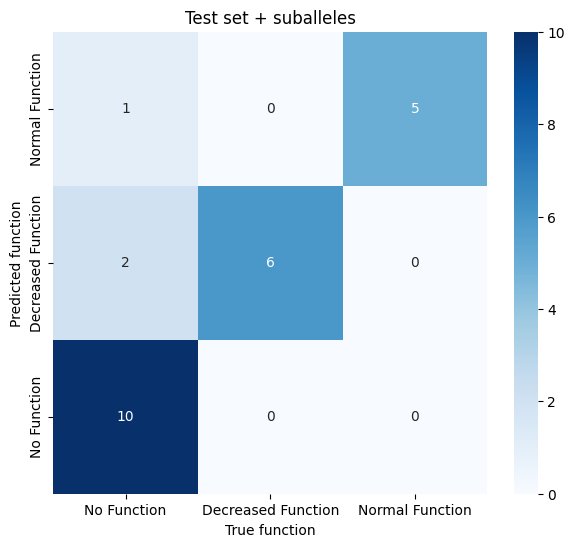

In [ ]:
# All test star alleles

test_ensemble = Ensemble(star_test_X)
test_labels = test_ensemble.get_functions(star_test_y)
test_heatmap = build_heatmap(test_ensemble.predictions, test_labels, labels)

fig = plt.figure()
fig.set_size_inches(7, 6)
sb.heatmap(test_heatmap, cmap="Blues", annot=test_heatmap, xticklabels=list(reversed(labels)), yticklabels=labels)
plt.xlabel("True function")
plt.ylabel("Predicted function")
plt.title("Test set + suballeles")

print("\nTest Accuracy:", test_ensemble.evaluate(star_test_y))

In [ ]:
predict_ubncertain_labels = Ensemble(uncurated_X)

Predicting...
3/3 [==============================] - 0s 23ms/step


In [ ]:
predict_ubncertain_labels.predictions

array(['No Function', 'Normal Function', 'No Function', 'No Function',
       'Normal Function', 'Normal Function', 'Normal Function',
       'Decreased Function', 'Normal Function', 'No Function',
       'Normal Function', 'Decreased Function', 'Normal Function',
       'Normal Function', 'Decreased Function', 'Normal Function',
       'Normal Function', 'Normal Function', 'Normal Function',
       'Normal Function', 'Decreased Function', 'No Function',
       'Normal Function', 'Decreased Function', 'Normal Function',
       'Normal Function', 'No Function', 'Decreased Function',
       'Normal Function', 'Decreased Function', 'Decreased Function',
       'Normal Function', 'Normal Function', 'Normal Function',
       'Normal Function', 'Decreased Function', 'Decreased Function',
       'Normal Function', 'Normal Function', 'Normal Function',
       'Normal Function', 'Normal Function', 'Decreased Function',
       'Decreased Function', 'Normal Function', 'Decreased Function',
      

In [ ]:
uncurated_samples

array(['CYP2D6_102_001', 'CYP2D6_103_001', 'CYP2D6_104_001',
       'CYP2D6_105_001', 'CYP2D6_106_001', 'CYP2D6_107_001',
       'CYP2D6_108_001', 'CYP2D6_109_001', 'CYP2D6_110_001',
       'CYP2D6_111_001', 'CYP2D6_112_001', 'CYP2D6_113_001',
       'CYP2D6_115_001', 'CYP2D6_116_001', 'CYP2D6_117_001',
       'CYP2D6_118_001', 'CYP2D6_119_001', 'CYP2D6_120_001',
       'CYP2D6_121_001', 'CYP2D6_122_001', 'CYP2D6_123_001',
       'CYP2D6_124_001', 'CYP2D6_125_001', 'CYP2D6_126_001',
       'CYP2D6_127_001', 'CYP2D6_128_001', 'CYP2D6_129_001',
       'CYP2D6_130_001', 'CYP2D6_131_001', 'CYP2D6_132_001',
       'CYP2D6_133_001', 'CYP2D6_134_001', 'CYP2D6_135_001',
       'CYP2D6_136_001', 'CYP2D6_137_001', 'CYP2D6_138_001',
       'CYP2D6_139_001', 'CYP2D6_22_001', 'CYP2D6_23_001',
       'CYP2D6_24_001', 'CYP2D6_25_001', 'CYP2D6_26_001', 'CYP2D6_28_001',
       'CYP2D6_30_001', 'CYP2D6_32_001', 'CYP2D6_37_001', 'CYP2D6_43_001',
       'CYP2D6_52_001', 'CYP2D6_58_001', 'CYP2D6_64_001', '

In [ ]:
np.array([f"*{uncurated.split('_')[1]}" for uncurated in uncurated_samples])

array(['*102', '*103', '*104', '*105', '*106', '*107', '*108', '*109',
       '*110', '*111', '*112', '*113', '*115', '*116', '*117', '*118',
       '*119', '*120', '*121', '*122', '*123', '*124', '*125', '*126',
       '*127', '*128', '*129', '*130', '*131', '*132', '*133', '*134',
       '*135', '*136', '*137', '*138', '*139', '*22', '*23', '*24', '*25',
       '*26', '*28', '*30', '*32', '*37', '*43', '*52', '*58', '*64',
       '*65', '*70', '*71', '*73', '*74', '*75', '*81', '*82', '*83',
       '*85', '*86', '*87', '*88', '*89', '*90', '*91', '*93', '*94',
       '*95', '*97', '*98'], dtype='<U4')

In [ ]:
data_frame = pd.DataFrame({'Uncertain': np.array([f"*{uncurated.split('_')[1]}" for uncurated in uncurated_samples]), 'Predict': predict_ubncertain_labels.predictions})

In [ ]:
data_frame

,Uncertain,Predict
0,*102,No Function
1,*103,Normal Function
2,*104,No Function
3,*105,No Function
4,*106,Normal Function
...,...,...
66,*93,Normal Function
67,*94,No Function
68,*95,Normal Function
69,*97,Normal Function


In [ ]:
data_frame.to_csv('../data/final_model/uncurated/predict.csv', index=False)

In [ ]:
star_alleles_predict = pd.read_csv('../data/final_model/uncurated/predict.csv')

In [ ]:
uncurated_predict = star_alleles_predict.copy()
alleles_function_predicted = alleles_function.copy()

In [ ]:
for index, row in uncurated_predict.iterrows():
    condition = alleles_function_predicted['CYP2D6 Star Allele'] == row['Uncertain']
    alleles_function_predicted.loc[condition, 'Curated Function'] = row['Predict']


In [ ]:
alleles_function_predicted

,CYP2D6 Star Allele,Curated Function
0,*1,Normal
1,*2,Normal
2,*3,No function
3,*4,No function
4,*6,No function
...,...,...
122,*135,Normal Function
123,*136,Normal Function
124,*137,Normal Function
125,*138,Decreased Function


In [ ]:
function_to_score = alleles_function_predicted.copy()
for index, row in function_to_score.iterrows():
    if row['Curated Function'] == 'Normal':
        function_to_score.iloc[index, 1] = 1
    elif row['Curated Function'] == 'Decreased Function':
        function_to_score.iloc[index, 1] = 0.5
    else:
        function_to_score.iloc[index, 1] = 0
    


In [ ]:
function_to_score = function_to_score.rename(columns={'Curated Function': 'Score'})
function_to_score

,CYP2D6 Star Allele,Score
0,*1,1
1,*2,1
2,*3,0
3,*4,0
4,*6,0
...,...,...
122,*135,0
123,*136,0
124,*137,0
125,*138,0.5


In [ ]:
gt_to_score = pd.read_csv('../data/final_model/CYP2D6_gt_to_score.txt', sep='\t')

In [ ]:
gt_to_score

,Allele,Activity Value,Source
0,*1,1.0,CPIC/PGKB allele table 8/23/21
1,*2,1.0,CPIC/PGKB allele table 8/23/21
2,*3,0.0,CPIC/PGKB allele table 8/23/21
3,*4,0.0,CPIC/PGKB allele table 8/23/21
4,*5,0.0,CPIC/PGKB allele table 8/23/21
...,...,...,...
132,*141,NaN,PharmVar 2.8
133,*142,NaN,PharmVar 2.8
134,*143,0.0,PharmVar 2.8
135,*144,NaN,PharmVar 2.8


In [ ]:
gt_to_score['reliability'] = '.'

for index, row in gt_to_score.iterrows():
    if pd.isna(row['Activity Value']):
        condition = function_to_score['CYP2D6 Star Allele'] == row['Allele']
        score = function_to_score.loc[condition, 'Score'].values
        if len(score) > 0:
            gt_to_score.iloc[index, 1] = score
            gt_to_score.iloc[index, 3] = 'Predict by model'



In [ ]:
gt_to_score

,Allele,Activity Value,Source,reliability
0,*1,1.0,CPIC/PGKB allele table 8/23/21,.
1,*2,1.0,CPIC/PGKB allele table 8/23/21,.
2,*3,0.0,CPIC/PGKB allele table 8/23/21,.
3,*4,0.0,CPIC/PGKB allele table 8/23/21,.
4,*5,0.0,CPIC/PGKB allele table 8/23/21,.
...,...,...,...,...
132,*141,NaN,PharmVar 2.8,.
133,*142,NaN,PharmVar 2.8,.
134,*143,0.0,PharmVar 2.8,.
135,*144,NaN,PharmVar 2.8,.


In [ ]:
gt_to_score.to_csv('../data/final_model/gt_to_score.txt', sep='\t', index=False, na_rep='N/A')